# Problem 2

In [1]:
import numpy as np
import pandas as pd
import wrds
import os
import matplotlib.pyplot as plt
import random
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import glob

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Part (a) (b)

## Data

In [7]:
# fetching data from WRDS
# def get_prices(ticker_list, db, period=('2010-01-01', '2020-12-31')):
#     if not ticker_list:
#       return pd.DataFrame(columns=["ticker", "secid", "effect_date"])
#
#     formatted_tickers = "', '".join(ticker_list)
#     query = f"""
#         SELECT permno, permco,htick, htsymbol
#         FROM crsp_a_stock.dsfhdr
#         WHERE htsymbol IN ('{formatted_tickers}')
#     """
#     df_permno =  db.raw_sql(query)
#     permno_lst = df_permno['permno'].astype(str).to_list()
#     formatted_permno = ",".join(permno_lst)
#     query = f"""
#         SELECT permno, date, prc, cfacpr
#         FROM crsp.dsf
#         WHERE permno IN ({formatted_permno})
#           AND date BETWEEN '{period[0]}' AND '{period[1]}'
#         ORDER BY permno, date;
#         """
#     df = db.raw_sql(query)
#     return df, df_permno
#
# # Read from csv
# # master_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/230P/problem_set_2/deliverables_q1/deliverables_q2/apple_stock.csv')
#
# db = wrds.Connection(wrds_username='jacoblan')
# df, info = get_prices(["AAPL"],db)
# df.to_parquet('aapl_prices_2010_2020.parquet', index=False)

In [3]:
# read data from parquet
df = pd.read_parquet('aapl_prices_2010_2020.parquet')

df['date'] = pd.to_datetime(df['date'])
df['adj_close'] = df['prc'] / df['cfacpr']
df = df.sort_values('date').reset_index(drop=True)

df.head()

,permno,date,prc,cfacpr,adj_close
0,14593,2010-01-04,214.00999,28.0,7.643214
1,14593,2010-01-05,214.38,28.0,7.656429
2,14593,2010-01-06,210.97,28.0,7.534643
3,14593,2010-01-07,210.58,28.0,7.520714
4,14593,2010-01-08,211.98,28.0,7.570714


## Bollinger Bands for Window Sizes 5 & 20

In [9]:
def compute_bb_labels(df, window, std=1):
    df = df.copy()
    df[f'SMA_{window}'] = df['adj_close'].rolling(window).mean()
    df[f'STD_{window}'] = df['adj_close'].rolling(window).std()
    df[f'Upper_BB_{window}'] = df[f'SMA_{window}'] + std * df[f'STD_{window}']
    df[f'Lower_BB_{window}'] = df[f'SMA_{window}'] - std * df[f'STD_{window}']

    def bb_label(row):
        if row['adj_close'] < row[f'Lower_BB_{window}']:
            return 'buy'
        elif row['adj_close'] > row[f'Upper_BB_{window}']:
            return 'sell'
        else:
            return None

    df[f'BB_label_{window}'] = df.apply(bb_label, axis=1)
    return df

## Short-Term Future Return Labels for 5 & 20 Days

In [10]:
def compute_future_labels(df, horizon):
    """
    Labels each row based on the price change from time t to t+horizon,
    following: +2% => 'buy', -2% => 'sell', else None.
    """
    df = df.copy()
    label_col = f'Future_label_{horizon}'
    df[label_col] = None

    for i in range(len(df) - horizon):
        start_price = df.iloc[i]['adj_close']
        end_price = df.iloc[i + horizon]['adj_close']
        pct_change = end_price / start_price - 1
        if pd.isnull(start_price) or pd.isnull(end_price):
            continue
        if pct_change >= 0.02:
            df.at[df.index[i], label_col] = 'buy'
        elif pct_change <= -0.02:
            df.at[df.index[i], label_col] = 'sell'

    return df


In [32]:
def compute_other_features(df, short_window=12, long_window=26):
    df = df.copy()
    df['EMA_short'] = df['adj_close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['adj_close'].ewm(span=long_window, adjust=False).mean()

    return df

## Save Price Charts for Each Configuration

In [33]:
def save_price_charts(df, window_size, label_col, base_dir,
                         price_color='black', upper_color='blue', lower_color='red', line_width=1):

    os.makedirs(base_dir, exist_ok=True)
    os.makedirs(f"{base_dir}/buy", exist_ok=True)
    os.makedirs(f"{base_dir}/sell", exist_ok=True)

    upper_col = f'Upper_BB_20'
    lower_col = f'Lower_BB_20'

    counter = 0
    for i in range(window_size - 1, len(df)):
        window_df = df.iloc[i - window_size + 1: i + 1]
        label = df.iloc[i][label_col]
        if not label or label not in ['buy', 'sell']:
            continue

        start_date = window_df.iloc[0]['date'].strftime('%Y%m%d')
        end_date = window_df.iloc[-1]['date'].strftime('%Y%m%d')
        filename = f"{base_dir}/{label}/img_{counter}_{start_date}_{end_date}.png"

        plt.figure(figsize=(2, 2))
        plt.plot(window_df['adj_close'].reset_index(drop=True), color=price_color, lw=3, label='Adj Close')
        plt.plot(window_df[upper_col].reset_index(drop=True), color=upper_color, lw=line_width, linestyle='--', label='Upper BB')
        plt.plot(window_df[lower_col].reset_index(drop=True), color=lower_color, lw=line_width, linestyle='--', label='Lower BB')
        
        if 'BB' not in label_col:
            plt.plot(window_df['EMA_short'].reset_index(drop=True), color='purple', lw=line_width, linestyle='-', label='EMA Short')
            plt.plot(window_df['EMA_long'].reset_index(drop=True), color='orange', lw=line_width, linestyle='-', label='EMA Long')

        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, dpi=100)
        plt.close()
        counter += 1

## BB and Future Gain Graphs — Window 5 and 20

In [34]:
# For Bollinger Bands labeling (keep your original compute_bb_labels code unchanged)
df_BB = compute_bb_labels(df, window=20)
df_fut = compute_future_labels(df_BB, horizon=5)
df_all = compute_other_features(df_fut)
df_all

,permno,date,prc,cfacpr,adj_close,SMA_20,STD_20,Upper_BB_20,Lower_BB_20,BB_label_20,Future_label_5,EMA_short,EMA_long
0,14593,2010-01-04,214.00999,28.0,7.643214,NaN,NaN,NaN,NaN,None,None,7.643214,7.643214
1,14593,2010-01-05,214.38,28.0,7.656429,NaN,NaN,NaN,NaN,None,sell,7.645247,7.644193
2,14593,2010-01-06,210.97,28.0,7.534643,NaN,NaN,NaN,NaN,None,None,7.628231,7.636078
3,14593,2010-01-07,210.58,28.0,7.520714,NaN,NaN,NaN,NaN,None,None,7.611690,7.627533
4,14593,2010-01-08,211.98,28.0,7.570714,NaN,NaN,NaN,NaN,None,sell,7.605386,7.623324
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,14593,2020-12-24,131.97,1.0,131.97,124.902750,4.190284,129.093035,120.712466,sell,None,127.698920,124.375567
2765,14593,2020-12-28,136.69,1.0,136.69,125.907750,4.491209,130.398959,121.416542,sell,None,129.082163,125.287747
2766,14593,2020-12-29,134.87,1.0,134.87,126.698751,4.611357,131.310108,122.087393,sell,None,129.972600,125.997543
2767,14593,2020-12-30,133.72,1.0,133.72,127.248750,4.765253,132.014004,122.483497,sell,None,130.549123,126.569577


In [36]:
save_price_charts(df_all, window_size=20, label_col='BB_label_20', base_dir='graphs_bb_win20')
save_price_charts(df_all, window_size=5, label_col='BB_label_20', base_dir='graphs_bb_win5')
save_price_charts(df_all, window_size=20, label_col='Future_label_5', base_dir='graphs_fut_win20')
save_price_charts(df_all, window_size=5, label_col='Future_label_5', base_dir='graphs_fut_win5')

## CNN Model

In [37]:
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


def get_image_and_labels(base_dir):
    X, y = [], []
    for label in ['buy', 'sell']:
        img_paths = glob.glob(f"{base_dir}/{label}/*.png")
        X.extend(img_paths)
        y.extend([0 if label == 'buy' else 1] * len(img_paths))
    return np.array(X), np.array(y)

def split_dataset(X, y, seed=SEED):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=2/3, random_state=seed, stratify=y_temp)
    return X_train, y_train, X_val, y_val, X_test, y_test

def preprocess_image(filepath, img_size=(64, 64)):
    img = tf.keras.utils.load_img(filepath, color_mode='rgb', target_size=img_size)
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    return img

def build_dataset(X, y):
    imgs = np.array([preprocess_image(fp) for fp in X])
    return imgs, np.array(y)

# Global results list
model_results = []

def train_and_evaluate(X, y, model_name, img_size = (64, 64)):
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, seed=SEED)
    X_train_img, y_train = build_dataset(X_train, y_train)
    X_val_img, y_val     = build_dataset(X_val, y_val)
    X_test_img, y_test   = build_dataset(X_test, y_test)

    model = models.Sequential([
        Input(shape=(img_size[0], img_size[1], 3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5)
    ]
    model.fit(
        X_train_img, y_train,
        validation_data=(X_val_img, y_val),
        epochs=25,
        batch_size=32,
        shuffle=True,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate
    y_train_pred = (model.predict(X_train_img, verbose=0) > 0.5).astype(int).flatten()
    y_test_pred  = (model.predict(X_test_img, verbose=0)  > 0.5).astype(int).flatten()
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test,  y_test_pred)

    model_results.append({
        "Model": model_name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
    })

    # (Keep your existing detailed output for full results if desired...)
    label_map = {0: "buy", 1: "sell"}
    print(f"\n{model_name}:")
    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test  accuracy: {test_acc:.3f}")
    print(f"\nTest results for {model_name}:")
    print(f"{'Test Image':40} | {'Predicted':8} | {'Actual':8}")
    print('-'*65)
    for fname, pred, actual in zip(X_test, y_test_pred, y_test):
        print(f"{os.path.basename(fname):40} | {label_map[pred]:8} | {label_map[actual]:8}")

    model.save(f"{model_name}.keras")
    np.savez(f"{model_name}_test_results.npz", X_test=X_test, y_test=y_test, y_pred=y_test_pred)

    return model

tasks = [
    ("BB_5",    "graphs_bb_win5"),
    ("BB_20",   "graphs_bb_win20"),
    ("Future_5","graphs_fut_win5"),
    ("Future_20","graphs_fut_win20")
]

for model_name, base_dir in tasks:
    if not os.path.exists(base_dir):
        print(f"Directory {base_dir} does not exist, skipping.")
        continue
    X, y = get_image_and_labels(base_dir)
    if len(X) == 0:
        print(f"No images found in {base_dir}")
        continue
    train_and_evaluate(X, y, model_name)


BB_5:
  Train accuracy: 1.000
  Test  accuracy: 1.000

Test results for BB_5:
Test Image                               | Predicted | Actual  
-----------------------------------------------------------------
img_1195_20181030_20181105.png           | buy      | buy     
img_936_20170103_20170109.png            | sell     | sell    
img_25_20100324_20100330.png             | sell     | sell    
img_1154_20180718_20180724.png           | sell     | sell    
img_206_20110715_20110721.png            | sell     | sell    
img_778_20151214_20151218.png            | buy      | buy     
img_448_20130312_20130318.png            | sell     | sell    
img_1101_20180315_20180321.png           | buy      | buy     
img_82_20100819_20100825.png             | buy      | buy     
img_1466_20200609_20200615.png           | sell     | sell    
img_180_20110518_20110524.png            | buy      | buy     
img_553_20140123_20140129.png            | buy      | buy     
img_970_20170228_20170306.png      

In [38]:
# Summary of accuracy result
results_df = pd.DataFrame(model_results)
print("\nSummary of Model Accuracies:")
print(results_df.to_string(index=False))


Summary of Model Accuracies:
    Model  Train Accuracy  Test Accuracy
     BB_5        1.000000       1.000000
    BB_20        1.000000       0.993590
 Future_5        0.608059       0.608974
Future_20        0.736406       0.632258


Example Input Image:


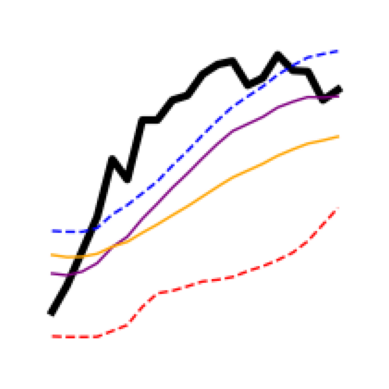

In [40]:
from PIL import Image

import matplotlib.pyplot as plt

print('Example Input Image:')
# Load and display the first image in X as an example
img_path = X[0]
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

### Summary
We start by turning every 5- or 20-day sliding window of AAPL adjusted-close prices into a 128 × 128 RGB chart that shows the price curve (plus its Bollinger-Band or ±2 % reference lines) and save it as a PNG. The colour channels are preserved so the CNN can learn that “blue dashed” means an upper band and “red dashed” a lower band instead of inferring that information from intensity alone. File paths are collected, stratified into a 70-10-20 random train/val/test split, and each image is loaded with tf.keras.utils.load_img(..., color_mode='rgb'), rescaled to [0,1], and stacked into tensors. The classification model is a small four-layer CNN: an input layer expecting (128,128,3), two conv–max-pool blocks (16 and 32 filters, 3×3 kernels, ReLU), a Flatten, one 32-unit dense layer, and a 1-unit sigmoid output. We compile it with Adam and binary cross-entropy, and train for up to 50 epochs with EarlyStopping (patience = 10, best-weight restore) so training halts automatically once validation loss stops improving. Finally, we evaluate on the held-out test set.

## Part (c)
Discuss why designing models using a random split in stock forecasting is problematic.

Designing models using a random split in stock forecasting is problematic primarily because it introduces ***look-ahead bias*** and leads to information leakage between the training and test sets. In financial time series like stock returns, the data is highly dependent on the order of time, future prices are influenced by past prices, not vice versa. A random split can mix data from different time periods in training, validation, and test sets, making it possible for the model to “see” patterns from the future during training.
As a result, the model’s performance may appear overly optimistic, since it’s being evaluated on data that, in reality, would not be known at prediction time. This misrepresents the model’s true predictive power in a real-world scenario, where only past and present data are available when forecasting future prices. Therefore, it is more appropriate to use chronological splits (e.g., train on earlier dates, validate and test on later dates) to ensure the model’s performance reflects its ability to generalize to unseen, future data—just like in actual trading.

# Model Test

In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score

SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from tensorflow.keras.models import load_model

SEED = 123
np.random.seed(SEED)

tasks = [
    ("BB_5",    "graphs_bb_win5"),
    ("BB_20",   "graphs_bb_win20"),
    ("Future_5","graphs_fut_win5"),
    ("Future_20","graphs_fut_win20")
]

model_results = []
for model_name, base_dir in tasks:
    # Load test set
    test_set_file = f"{model_name}_test_set.npz"
    if not os.path.exists(test_set_file):
        print(f"Test set file {test_set_file} not found, skipping {model_name}.")
        continue
    data = np.load(test_set_file, allow_pickle=True)
    print(data)
    X_test = data['X_test']
    y_test = data['y_test']
    X_imgs = data['X_imgs']

    # Randomly select 30 indices
    if len(X_test) < 30:
        print(f"Not enough test samples for {model_name}, found {len(X_test)}.")
        continue
    idx = np.random.choice(len(X_test), 30, replace=False)
    X_sample = X_test[idx]
    X_sample_imgs = X_imgs[idx]
    y_sample = y_test[idx]

    # Load model
    model_file = f"{model_name}.keras"
    if not os.path.exists(model_file):
        print(f"Model file {model_file} not found, skipping {model_name}.")
        continue
    model = load_model(model_file)

    y_pred = (model.predict(X_sample_imgs, verbose=0) > 0.5).astype(int).flatten()

    label_map = {0: "buy", 1: "sell"}
    print(f"\n{model_name} - 30 Random Test Samples:")
    print(f"{'Test Image':40} | {'Predicted':8} | {'Actual':8}")
    print('-'*65)
    for fname, pred, actual in zip(X_sample, y_pred, y_sample):
        print(f"{os.path.basename(fname):40} | {label_map[pred]:8} | {label_map[actual]:8}")
    acc = accuracy_score(y_sample, y_pred)
    print(f"Accuracy on 30 random samples: {acc:.3f}")

    model_results.append({
        "Model": model_name,
        "Accuracy": acc,
    })

NpzFile 'BB_5_test_set.npz' with keys: X_test, y_test, X_imgs

BB_5 - 30 Random Test Samples:
Test Image                               | Predicted | Actual  
-----------------------------------------------------------------
img_1070_20190117_20190124.png           | buy      | buy     
img_729_20160329_20160404.png            | sell     | sell    
img_118_20101228_20110103.png            | sell     | sell    
img_979_20180501_20180507.png            | sell     | sell    
img_349_20121101_20121107.png            | buy      | buy     
img_798_20161005_20161011.png            | sell     | sell    
img_1071_20190118_20190125.png           | sell     | sell    
img_544_20140808_20140814.png            | sell     | sell    
img_850_20170314_20170320.png            | sell     | sell    
img_1126_20190716_20190722.png           | sell     | sell    
img_941_20180111_20180118.png            | sell     | sell    
img_1132_20190807_20190813.png           | sell     | sell    
img_531_20140627_201

In [3]:
# Summary of accuracy result
results_df = pd.DataFrame(model_results)
print("\nSummary of Model Accuracies on 30 random samples:")
print(results_df.to_string(index=False))


Summary of Model Accuracies on 30 random samples:
    Model  Accuracy
     BB_5  0.866667
    BB_20  1.000000
 Future_5  0.633333
Future_20  0.766667
